In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pylab as plt

In [2]:
df = pd.read_csv('AirPassengers.csv',header=0,encoding='utf-8', index_col=0)
df.index.name='date'
df.index = pd.to_datetime(df.index)  # 将字符串索引转换成时间索引
ts = df['NumPassengers']  # 生成pd.Series对象
ts.head()

date
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: NumPassengers, dtype: int64

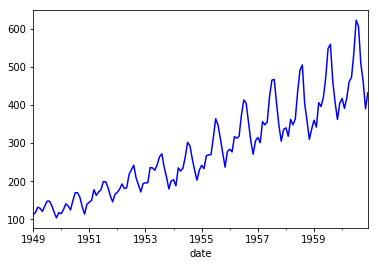

In [3]:
def draw_ts(timeSeries):
    f = plt.figure(facecolor='white')
    timeSeries.plot(color='blue')
    plt.show()
draw_ts(ts)

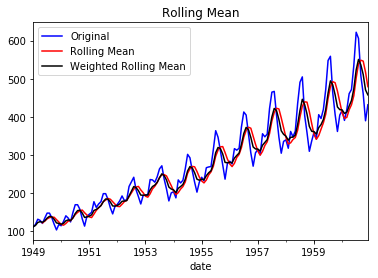

In [4]:
# 移动平均图
def draw_trend(timeSeries, size):
    f = plt.figure(facecolor='white')
    # 对size个数据进行移动平均
    rol_mean = timeSeries.rolling(window=size).mean()
    # 对size个数据进行加权移动平均
    rol_weighted_mean = timeSeries.ewm( span=size).mean()
    timeSeries.plot(color='blue', label='Original')
    rol_mean.plot(color='red', label='Rolling Mean')
    rol_weighted_mean.plot(color='black', label='Weighted Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show()
draw_trend(ts, size=5)

C:\Users\guofei\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


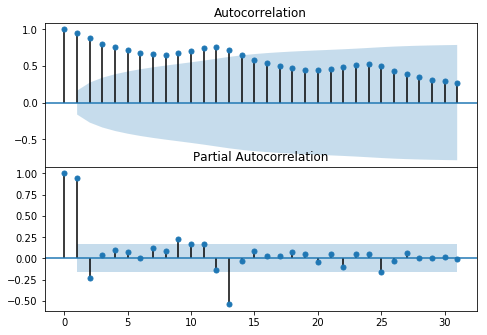

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# 自相关和偏相关图
def draw_acf_pacf(ts, lags=31):
    f = plt.figure(facecolor='white')
    ax1 = f.add_subplot(211)
    plot_acf(ts, lags=31, ax=ax1)
    ax2 = f.add_subplot(212)
    plot_pacf(ts, lags=31, ax=ax2)
    plt.subplots_adjust(0,0,1,1,0,0)
    plt.show()
draw_acf_pacf(ts)

||AR(p)|MA(q)|ARMA(p,q)|
|--|--|--|--|
|ACF|拖尾|q期后截尾|拖尾|
|PACF|p期后截尾|拖尾|拖尾|

In [6]:
from statsmodels.tsa.stattools import adfuller

'''
　　Unit Root Test
   The null hypothesis of the Augmented Dickey-Fuller is that there is a unit
   root, with the alternative that there is no unit root. That is to say the
   bigger the p-value the more reason we assert that there is a unit root
'''
def testStationarity(ts):
    dftest = adfuller(ts)
    # 对上述函数求得的值进行语义描述
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

testStationarity(ts)

Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64

H0：存在单位根，此时非平稳  
案例汇中p较大，因此不能拒绝原假设。认为时间序列不平稳

## 平稳性处理
- 对数变换
- 差分
- 趋势+周期分解


### 1. 对数变换

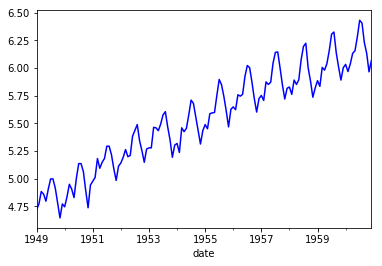

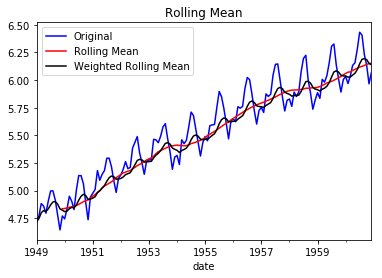

In [7]:
ts_log = np.log(ts)
draw_ts(ts_log)
draw_trend(ts_log, 12)

### 2. 差分法

In [8]:
diff_12 = ts_log.diff(12)
diff_12.dropna(inplace=True)
diff_12_1 = diff_12.diff(1)
diff_12_1.dropna(inplace=True)
testStationarity(diff_12_1)

Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64

因此使用diff_12_1来做ARMA

### 3. 趋势分解

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model="additive")
# model="additive" 加法模型
# model='multiplicative' 乘法模型


trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

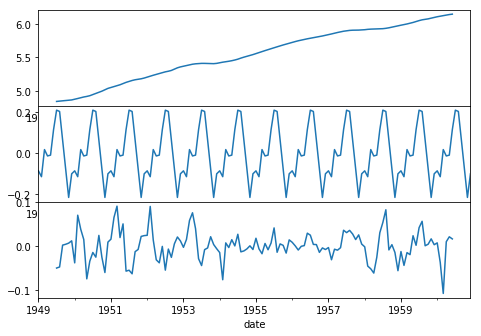

In [10]:
f=plt.figure()
ax1 = f.add_subplot(311)
trend.plot()
ax2 = f.add_subplot(312)
seasonal.plot()
ax3 = f.add_subplot(313)
residual.plot()
plt.subplots_adjust(0,0,1,1,0,0)
plt.show()

## ARMA
(我们选用移动平均和差分法生成的平稳数据)

In [11]:
rol_mean = ts_log.rolling(window=12).mean()
rol_mean.dropna(inplace=True)
ts_diff_1 = rol_mean.diff(1)
ts_diff_1.dropna(inplace=True)
testStationarity(ts_diff_1)

Test Statistic                  -2.709577
p-value                          0.072396
#Lags Used                      12.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64

不显著，因此再次diff

In [12]:
ts_diff_2 = ts_diff_1.diff(1)
ts_diff_2.dropna(inplace=True)
testStationarity(ts_diff_2)

Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64

In [13]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(ts_diff_2, order=(1, 1)) #order=(1,1,1)就是ARIMA
result_arma = model.fit( disp=-1, method='css')

C:\Users\guofei\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [14]:
result_arma.aic
result_arma.arparams
result_arma.maparams

array([-0.54041223])

### 预测

In [15]:
predict_ts=result_arma.predict()

In [16]:
predict_ts = result_arma.predict()
# 一阶差分还原
diff_shift_ts = ts_diff_1.shift(1)
diff_recover_1 = predict_ts.add(diff_shift_ts)
# 再次一阶差分还原
rol_shift_ts = rol_mean.shift(1)
diff_recover = diff_recover_1.add(rol_shift_ts)
# 移动平均还原
rol_sum = ts_log.rolling(window=11).sum()
rol_recover = diff_recover*12 - rol_sum.shift(1)
# 对数还原
log_recover = np.exp(rol_recover)
log_recover.dropna(inplace=True)

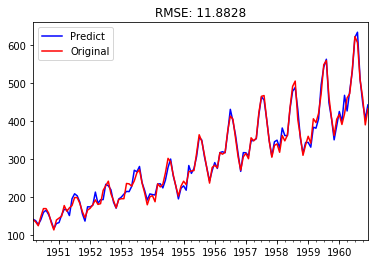

In [17]:
ts = ts[log_recover.index]  # 过滤没有预测的记录
plt.figure(facecolor='white')
log_recover.plot(color='blue', label='Predict')
ts.plot(color='red', label='Original')
plt.legend(loc='best')
plt.title('RMSE: %.4f'% np.sqrt(sum((log_recover-ts)**2)/ts.size))
plt.show()

参考资料：https://www.cnblogs.com/foley/p/5582358.html